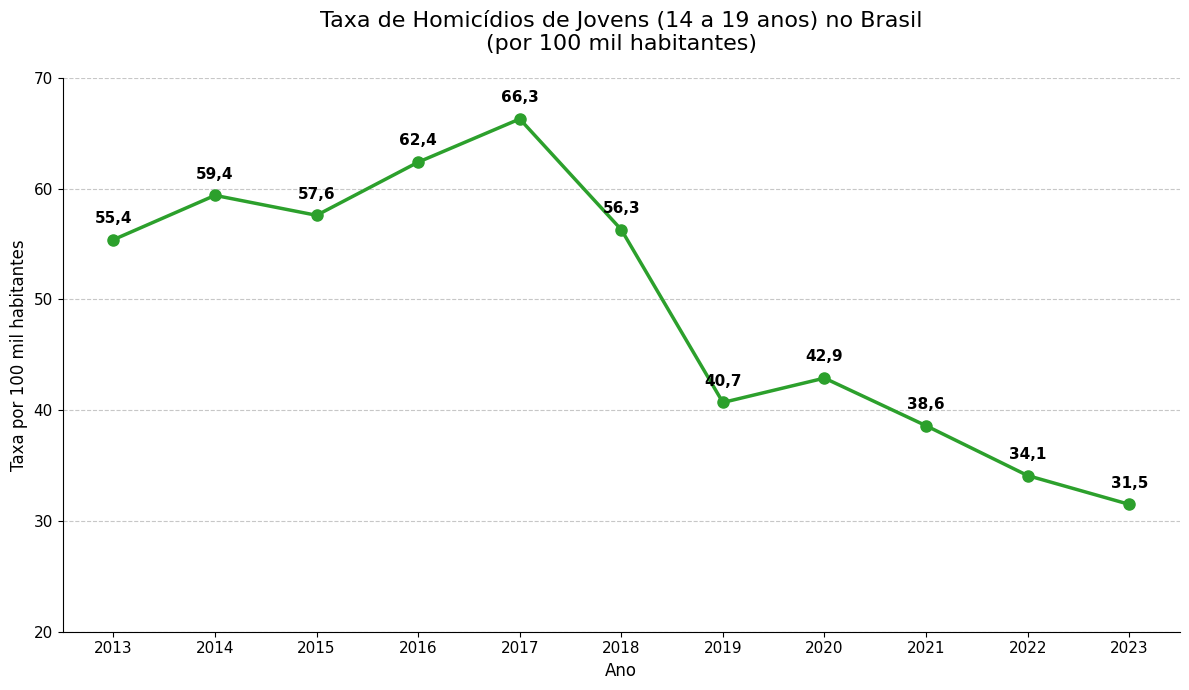

In [5]:
import matplotlib.pyplot as plt

# Dados extraídos da imagem
anos = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
taxas = [55.4, 59.4, 57.6, 62.4, 66.3, 56.3, 40.7, 42.9, 38.6, 34.1, 31.5]

# Configuração do gráfico
plt.figure(figsize=(12, 7))
plt.plot(anos, taxas, marker='o', linestyle='-', color='#2ca02c', linewidth=2.5, markersize=8, label='Taxa de Homicídios')

# Adicionando os valores sobre cada ponto
for i, taxa in enumerate(taxas):
    plt.annotate(f'{taxa}'.replace('.', ','), 
                 (anos[i], taxas[i]), 
                 textcoords="offset points", 
                 xytext=(0, 12), 
                 ha='center',
                 fontsize=11,
                 fontweight='bold')

# Personalização dos eixos e título
plt.title('Taxa de Homicídios de Jovens (14 a 19 anos) no Brasil\n(por 100 mil habitantes)', fontsize=16, pad=20)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Taxa por 100 mil habitantes', fontsize=12)
plt.xticks(anos, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Ajustando os limites do eixo Y para melhor visualização (começando de 0 para dar perspectiva correta)
plt.ylim(20, 70.0)

# Removendo as bordas superior e direita para um visual mais limpo
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

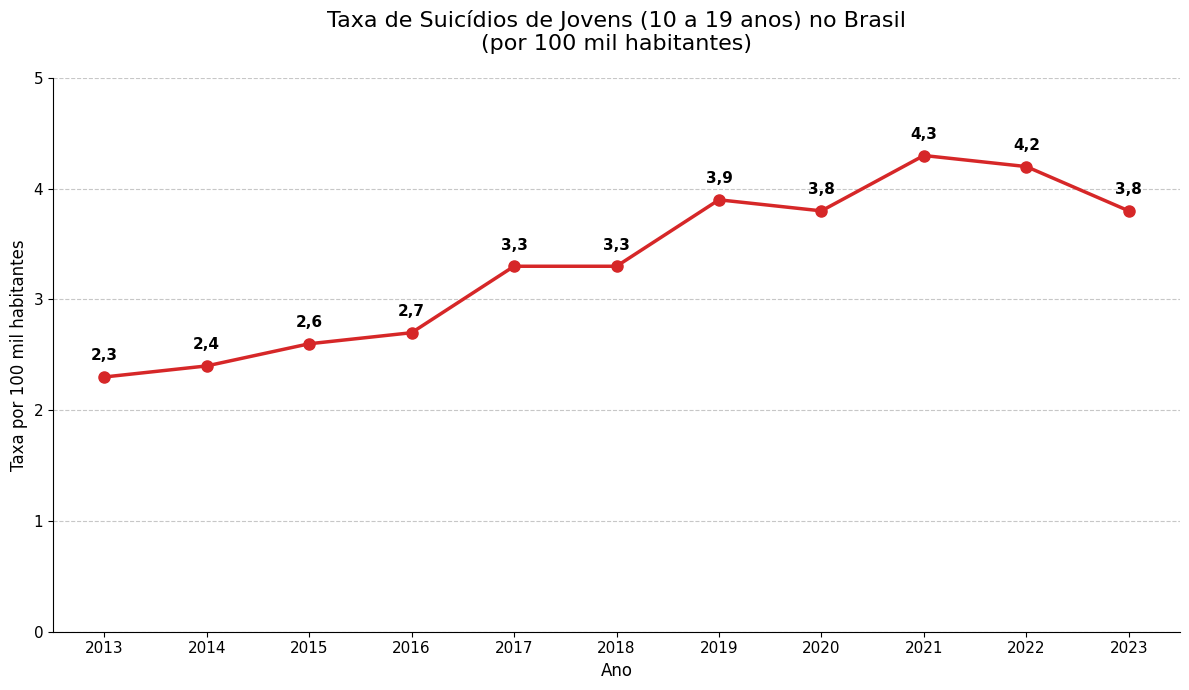

In [1]:
import matplotlib.pyplot as plt

# Dados extraídos da Tabela 4.15
anos = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
taxas = [2.3, 2.4, 2.6, 2.7, 3.3, 3.3, 3.9, 3.8, 4.3, 4.2, 3.8]

# Configuração do gráfico
plt.figure(figsize=(12, 7))
# Usando uma cor avermelhada (#d62728) para diferenciar do gráfico anterior
plt.plot(anos, taxas, marker='o', linestyle='-', color='#d62728', linewidth=2.5, markersize=8, label='Taxa de Suicídios')

# Adicionando os valores sobre cada ponto
for i, taxa in enumerate(taxas):
    plt.annotate(f'{taxa}'.replace('.', ','), 
                 (anos[i], taxas[i]), 
                 textcoords="offset points", 
                 xytext=(0, 12), 
                 ha='center',
                 fontsize=11,
                 fontweight='bold')

# Personalização dos eixos e título
plt.title('Taxa de Suicídios de Jovens (10 a 19 anos) no Brasil\n(por 100 mil habitantes)', fontsize=16, pad=20)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Taxa por 100 mil habitantes', fontsize=12)
plt.xticks(anos, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Ajustando os limites do eixo Y para melhor visualização (começando de 0 até um pouco acima do máximo)
plt.ylim(0, 5.0)

# Removendo as bordas superior e direita para um visual mais limpo
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()